<a href="https://colab.research.google.com/github/Vishwajeet111/Classification-of-Leaves-disease/blob/master/Transfer%20Learning%20(Feature_extraction)%20on%20VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_size = 256
channels = 3

In [4]:
def ImageAugmentation(location, shuffle):
  datagen = ImageDataGenerator(
      rescale = 1./255, rotation_range = 10, horizontal_flip = True)
  image_generator = datagen.flow_from_directory(
      location, target_size = (image_size, image_size),batch_size = 32,class_mode = "sparse", shuffle = shuffle)

  return image_generator

In [5]:
train_generator = ImageAugmentation('/content/drive/MyDrive/Colab Notebooks/Leaves_image_CNN_training/train',shuffle = True)
test_generator = ImageAugmentation('/content/drive/MyDrive/Colab Notebooks/Leaves_image_CNN_training/test',shuffle = False)
val_generator = ImageAugmentation('/content/drive/MyDrive/Colab Notebooks/Leaves_image_CNN_training/val',shuffle = True)

Found 21472 images belonging to 19 classes.
Found 2700 images belonging to 19 classes.
Found 2678 images belonging to 19 classes.


In [6]:
# printing the class names
class_name = list(train_generator.class_indices.keys())
print(class_name)

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [7]:
from keras.applications.vgg19 import VGG19
from keras import Sequential
from keras.layers import Dense, Flatten

In [8]:
conv_base = VGG19(
    weights = "imagenet",
    include_top = False,
    input_shape = (image_size,image_size,channels)
)
conv_base.trainable = False

80134624/80134624 [==============================] - 3s 0us/step


In [9]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [11]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(19,activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               8388864   
                                                                 
 dense_3 (Dense)             (None, 19)                4883      
                                                                 
Total params: 28,418,131
Trainable params: 8,393,747
Non-trainable params: 20,024,384
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor="val_loss",min_delta=0.00001,patience=2,verbose=1,mode="auto",baseline=None,restore_best_weights=False)

In [13]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [14]:
history = model.fit(
    train_generator,steps_per_epoch=len(train_generator),batch_size=32,validation_data=val_generator,
    validation_steps=len(val_generator),verbose=1,epochs=10,callbacks=callback)

Epoch 1/10
671/671 [==============================] - 11550s 17s/step - loss: 0.7850 - accuracy: 0.7717 - val_loss: 0.4496 - val_accuracy: 0.8518
Epoch 2/10
671/671 [==============================] - 423s 630ms/step - loss: 0.3567 - accuracy: 0.8793 - val_loss: 0.3218 - val_accuracy: 0.8872
Epoch 3/10
671/671 [==============================] - 426s 635ms/step - loss: 0.2763 - accuracy: 0.9033 - val_loss: 0.2920 - val_accuracy: 0.8958
Epoch 4/10
671/671 [==============================] - 419s 624ms/step - loss: 0.2416 - accuracy: 0.9162 - val_loss: 0.3812 - val_accuracy: 0.8760
Epoch 5/10
671/671 [==============================] - 424s 631ms/step - loss: 0.2226 - accuracy: 0.9232 - val_loss: 0.2909 - val_accuracy: 0.8981
Epoch 6/10
671/671 [==============================] - 426s 634ms/step - loss: 0.1774 - accuracy: 0.9379 - val_loss: 0.2582 - val_accuracy: 0.9119
Epoch 7/10
671/671 [==============================] - 437s 651ms/step - loss: 0.1716 - accuracy: 0.9400 - val_loss: 0.2829 -

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('The accuracy of the testing dataset is {} and the loss of the testing dataset is {}'.format(test_accuracy*100, test_loss*100))

85/85 [==============================] - 1317s 16s/step - loss: 0.2725 - accuracy: 0.9085
The accuracy of the testing dataset is 90.85184931755066 and the loss of the testing dataset is 27.248230576515198


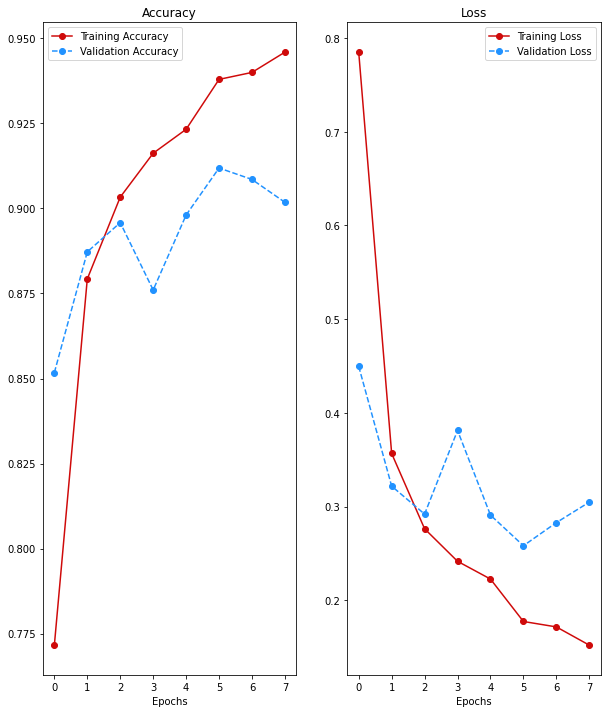

In [16]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(8)

plt.rcParams['figure.figsize'] = (10,12)
plt.subplot(1,2,1)
plt.plot(epochs_range, accuracy,'-o', label='Training Accuracy',color="#CF0A0A")
plt.plot(epochs_range, val_accuracy,'o--', label='Validation Accuracy',color="#2192FF")
plt.xlabel("Epochs")
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss,'-o', label='Training Loss',color="#CF0A0A")
plt.plot(epochs_range, val_loss,'o--', label='Validation Loss',color="#2192FF")
plt.xlabel("Epochs")
plt.legend()
plt.title('Loss')
plt.show();

In [17]:
y_prob = model.predict(test_generator, verbose = True)
y_pred = np.argmax(y_prob, axis=1)

85/85 [==============================] - 48s 565ms/step


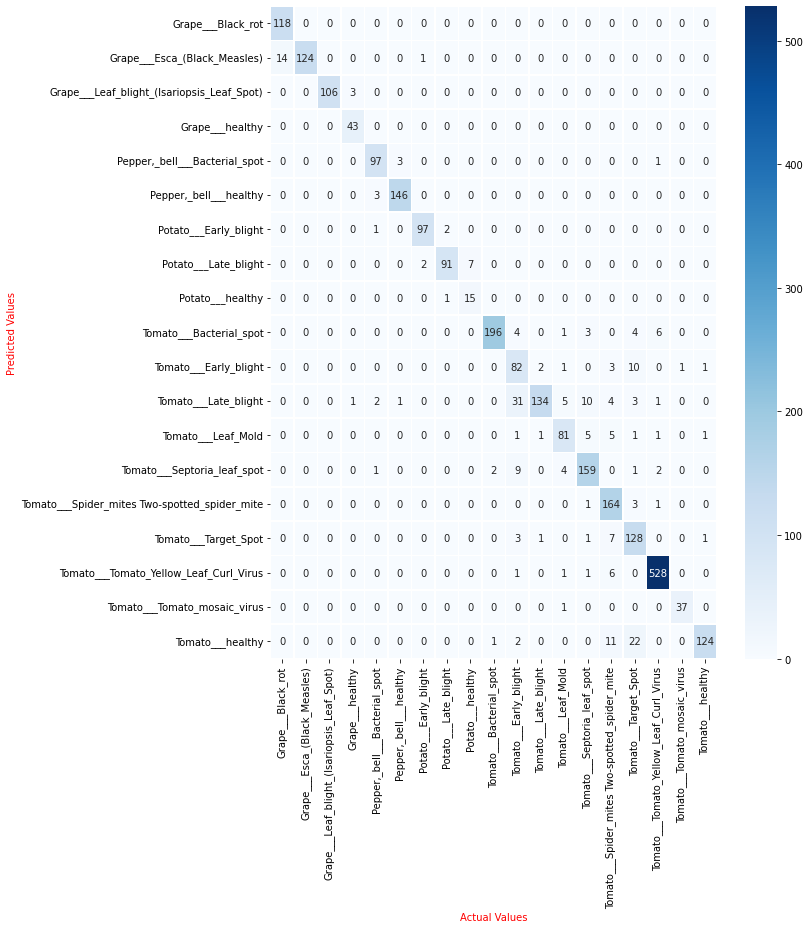

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm,annot=True,cmap="Blues",fmt='g',linewidth=.5,xticklabels=class_name,yticklabels=class_name)
plt.xlabel("Actual Values",size=10,color='red')
plt.ylabel("Predicted Values",size=10,color='red')
plt.show()

In [21]:
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                                               precision    recall  f1-score   support

                            Grape___Black_rot       0.89      1.00      0.94       118
                 Grape___Esca_(Black_Measles)       1.00      0.89      0.94       139
   Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      0.97      0.99       109
                              Grape___healthy       0.91      1.00      0.96        43
                Pepper,_bell___Bacterial_spot       0.93      0.96      0.95       101
                       Pepper,_bell___healthy       0.97      0.98      0.98       149
                        Potato___Early_blight       0.97      0.97      0.97       100
                         Potato___Late_blight       0.97      0.91      0.94       100
                             Potato___healthy       0.68      0.94      0.79        16
                      Tomato___Bacterial_spot       0.98      0.92      0.95       214
                        Tomato___Early_bli

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [23]:
test_generator.shuffle = True

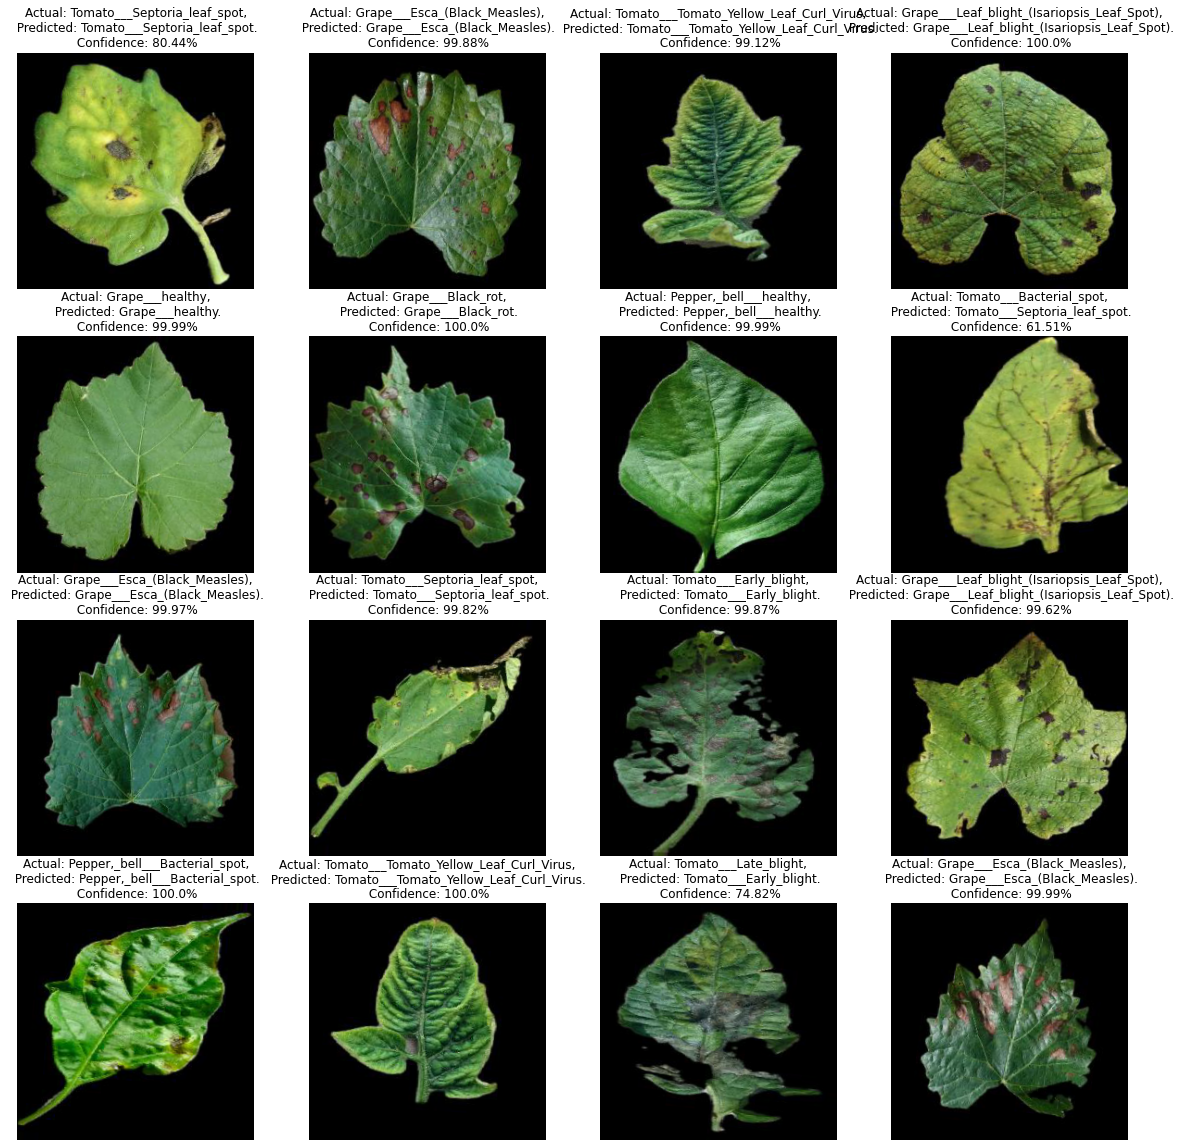

In [27]:
plt.figure(figsize=(20, 20))
for images, labels in test_generator:
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_name[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [28]:
model.save('DeepLearning_VGG19.h5')